In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import RobertaForSequenceClassification, RobertaTokenizer, DataCollatorWithPadding
from transformers.optimization import get_linear_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# class Config:
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     max_len = 128
#     teacher_epochs = [2, 3, 4]
#     teacher_lrs = [1e-5, 2e-5, 3e-5, 5e-5]  # Added smaller lr for finer tuning
#     teacher_batch_sizes = [16, 32]
#     teacher_weight_decays = [0.0, 0.01]
#     teacher_freeze_configs = [0, 2, 4, 6, 8, 10]  # Number of RoBERTa layers to freeze
#     output_teacher_model = "best_teacher_model.pt"

# Configuration
class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    max_len = 128
    teacher_epochs = [2, 3]
    teacher_lrs = [1e-5, 2e-5, 3e-5, 5e-5]  # Added smaller lr for finer tuning
    teacher_batch_sizes = [16, 32]
    teacher_weight_decays = [0.0, 0.01]
    teacher_freeze_configs = [0]  # Number of RoBERTa layers to freeze
    output_teacher_model = "best_teacher_model.pt"

# Verify GPU Availability
print(f"Using device: {Config.device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU detected. Falling back to CPU.")

# Custom Data Collator
class CustomDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.padding_collator = DataCollatorWithPadding(tokenizer)

    def __call__(self, examples):
        features = [{"input_ids": ex["input_ids"], "attention_mask": ex["attention_mask"]} for ex in examples]
        labels = [ex["label"] for ex in examples]
        padded = self.padding_collator(features)
        padded["label"] = torch.tensor(labels, dtype=torch.long)
        return padded

# Freeze Transformer Layers
def freeze_transformer_layers(model, freeze_n):
    """Freeze the specified number of RoBERTa encoder layers."""
    if hasattr(model, 'roberta'):
        backbone = model.roberta
    else:
        raise ValueError("Model does not have 'roberta' attribute.")
    
    # Freeze embeddings if freeze_n > 0
    for param in backbone.embeddings.parameters():
        param.requires_grad = False if freeze_n > 0 else True
    
    # Freeze encoder layers
    for i, layer in enumerate(backbone.encoder.layer):
        for param in layer.parameters():
            param.requires_grad = (i >= freeze_n)
    
    # Ensure classifier is trainable
    for param in model.classifier.parameters():
        param.requires_grad = True

# Evaluation Function
def evaluate(model, dataloader, device, model_name="Teacher"):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"],
                yticklabels=["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Classification Report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"]))
    
    return total_loss / len(dataloader), acc, f1, all_preds, all_labels

# Teacher Training with Plots
def train_teacher(model, train_loader, val_loader, epochs, lr, weight_decay, device, freeze_n):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)
    best_acc = 0.0
    best_state_dict = None
    train_losses, val_losses, train_accs, val_accs = [], [], [], []  # Fixed unpacking error
    
    print(f"Training teacher with freeze_n={freeze_n} on {device}")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []
        for batch in tqdm(train_loader, desc=f"Teacher Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"[Teacher] Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, device, model_name="Teacher")
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"[Teacher] Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_state_dict = model.state_dict()

    # Plot Training and Validation Metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Teacher Loss Curve')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Teacher Accuracy Curve')
    plt.legend()
    plt.show()
    
    return best_acc, best_state_dict

# Main Function
def main():
    # Load Dataset
    print("Loading PubMed RCT dataset...")
    dataset = load_dataset(
        "csv",
        data_files={
            "train": "data/train.txt",
            "validation": "data/dev.txt",
            "test": "data/test.txt"
        },
        delimiter="\t",
        column_names=["label", "text"]
    )

    # Filter out non-data lines (e.g., document IDs starting with ###)
    valid_labels = {"BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"}
    dataset = dataset.filter(lambda x: x["label"] in valid_labels)
    train_dataset = dataset["train"]
    val_dataset = dataset["validation"]
    test_dataset = dataset["test"]

    # Define Label Map
    label_map = {"BACKGROUND": 0, "OBJECTIVE": 1, "METHODS": 2, "RESULTS": 3, "CONCLUSIONS": 4}
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

    # Preprocess Function
    def preprocess(example):
        encoding = tokenizer(
            example["text"],
            max_length=Config.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        label = label_map[example["label"]]
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": label
        }

    # Apply Preprocessing
    train_dataset = train_dataset.map(preprocess)
    val_dataset = val_dataset.map(preprocess)
    test_dataset = test_dataset.map(preprocess)
    train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    # Grid Search for Teacher
    print("\nStarting RoBERTa fine-tuning grid search...")
    teacher_results = []
    best_teacher_acc = 0.0
    best_teacher_state = None
    best_teacher_config = None

    for freeze_n in Config.teacher_freeze_configs:
        for epochs in Config.teacher_epochs:
            for lr in Config.teacher_lrs:
                for batch_size in Config.teacher_batch_sizes:
                    for weight_decay in Config.teacher_weight_decays:
                        print(f"\nTesting freeze_n={freeze_n}, epochs={epochs}, lr={lr}, batch_size={batch_size}, weight_decay={weight_decay}")
                        teacher = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=5).to(Config.device)
                        freeze_transformer_layers(teacher, freeze_n)
                        data_collator = CustomDataCollator(tokenizer=tokenizer)
                        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
                        val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=data_collator)
                        acc, state_dict = train_teacher(teacher, train_loader, val_loader, epochs, lr, weight_decay, Config.device, freeze_n)
                        teacher_results.append({
                            "freeze_n": freeze_n,
                            "epochs": epochs,
                            "lr": lr,
                            "batch_size": batch_size,
                            "weight_decay": weight_decay,
                            "val_acc": acc
                        })
                        if acc > best_teacher_acc:
                            best_teacher_acc = acc
                            best_teacher_state = state_dict
                            best_teacher_config = {
                                "freeze_n": freeze_n,
                                "epochs": epochs,
                                "lr": lr,
                                "batch_size": batch_size,
                                "weight_decay": weight_decay
                            }
                            torch.save(state_dict, Config.output_teacher_model)
                            print(f"*** New best teacher model saved with val_acc={acc:.4f} ***")

    # Save Grid Search Results
    with open("teacher_grid_results.json", "w") as f:
        json.dump(teacher_results, f, indent=2)

    # Load and Evaluate Best Teacher on Test Set
    print("\nEvaluating best teacher model on test set...")
    teacher = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=5).to(Config.device)
    teacher.load_state_dict(torch.load(Config.output_teacher_model))
    test_loader = DataLoader(test_dataset, batch_size=best_teacher_config["batch_size"], collate_fn=data_collator)
    _, teacher_acc, teacher_f1, _, _ = evaluate(teacher, test_loader, Config.device, model_name="Teacher")
    print(f"Teacher Final Test Accuracy: {teacher_acc:.4f}, F1 Score: {teacher_f1:.4f}")

if __name__ == "__main__":
    main()

g:\ML\Lightweight BERT with Knowledge Distillation for Low-Resource Text Classification\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

g:\ML\Lightweight BERT with Knowledge Distillation for Low-Resource Text Classification\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Ti
CUDA Version: 11.8
Loading PubMed RCT dataset...

Starting RoBERTa fine-tuning grid search...

Testing freeze_n=2, epochs=3, lr=1e-05, batch_size=16, weight_decay=0.01


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training teacher with freeze_n=2 on cuda


Teacher Epoch 1: 100%|██████████| 11253/11253 [29:52<00:00,  6.28it/s]


[Teacher] Epoch 1, Train Loss: 0.4591, Train Accuracy: 0.8277


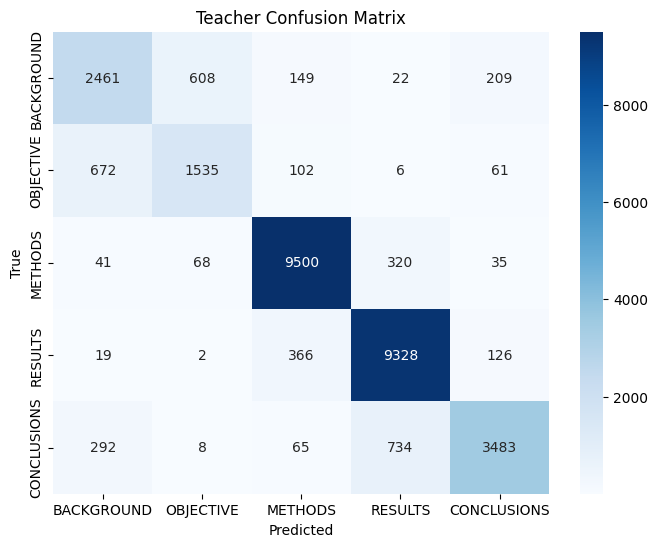


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.71      0.71      0.71      3449
   OBJECTIVE       0.69      0.65      0.67      2376
     METHODS       0.93      0.95      0.94      9964
     RESULTS       0.90      0.95      0.92      9841
 CONCLUSIONS       0.89      0.76      0.82      4582

    accuracy                           0.87     30212
   macro avg       0.82      0.80      0.81     30212
weighted avg       0.87      0.87      0.87     30212

[Teacher] Epoch 1, Val Loss: 0.3502, Accuracy: 0.8707, F1 Score: 0.8690


Teacher Epoch 2: 100%|██████████| 11253/11253 [29:48<00:00,  6.29it/s]


[Teacher] Epoch 2, Train Loss: 0.3363, Train Accuracy: 0.8769


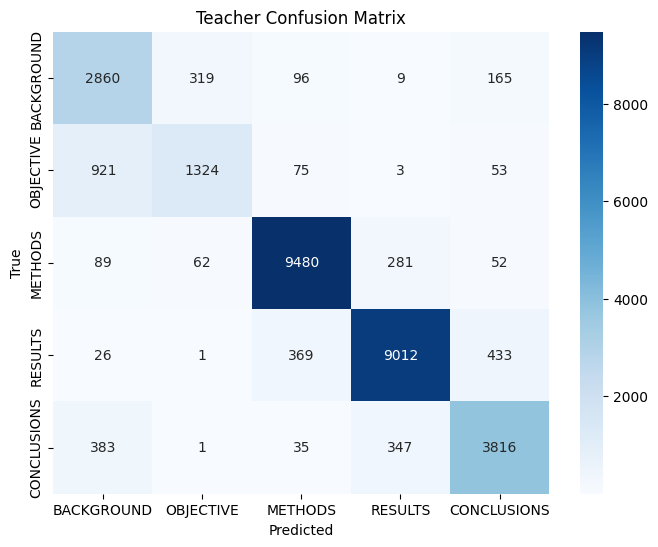


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.67      0.83      0.74      3449
   OBJECTIVE       0.78      0.56      0.65      2376
     METHODS       0.94      0.95      0.95      9964
     RESULTS       0.93      0.92      0.92      9841
 CONCLUSIONS       0.84      0.83      0.84      4582

    accuracy                           0.88     30212
   macro avg       0.83      0.82      0.82     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 2, Val Loss: 0.3334, Accuracy: 0.8769, F1 Score: 0.8762


Teacher Epoch 3: 100%|██████████| 11253/11253 [29:44<00:00,  6.31it/s]


[Teacher] Epoch 3, Train Loss: 0.2971, Train Accuracy: 0.8909


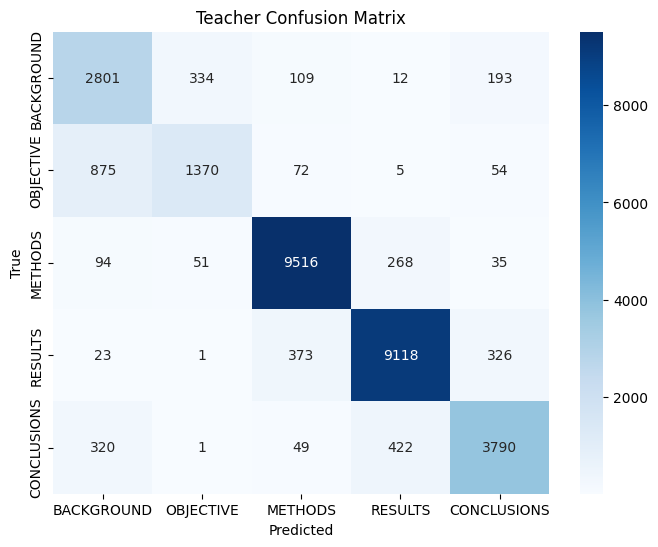


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.68      0.81      0.74      3449
   OBJECTIVE       0.78      0.58      0.66      2376
     METHODS       0.94      0.96      0.95      9964
     RESULTS       0.93      0.93      0.93      9841
 CONCLUSIONS       0.86      0.83      0.84      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.82      0.82     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 3, Val Loss: 0.3267, Accuracy: 0.8803, F1 Score: 0.8793


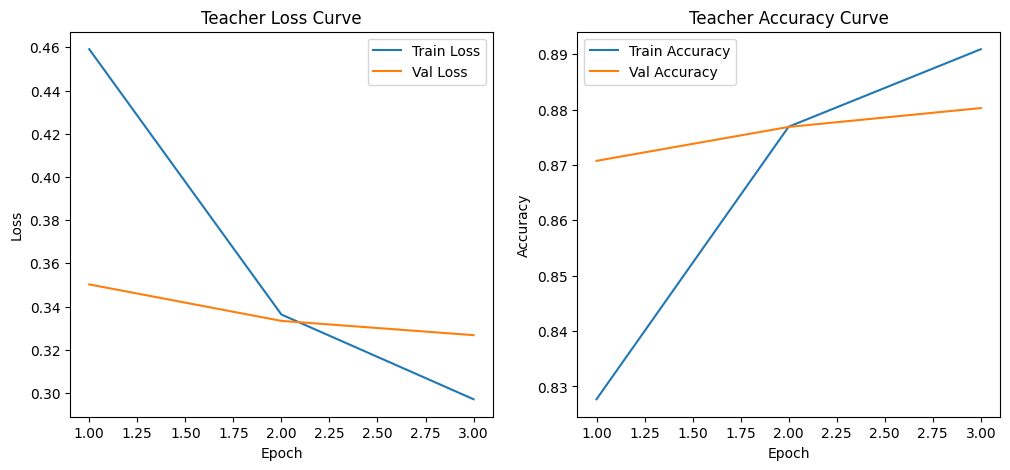

*** New best teacher model saved with val_acc=0.8803 ***

Testing freeze_n=2, epochs=3, lr=2e-05, batch_size=16, weight_decay=0.01


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training teacher with freeze_n=2 on cuda


Teacher Epoch 1: 100%|██████████| 11253/11253 [30:08<00:00,  6.22it/s]


[Teacher] Epoch 1, Train Loss: 0.4490, Train Accuracy: 0.8333


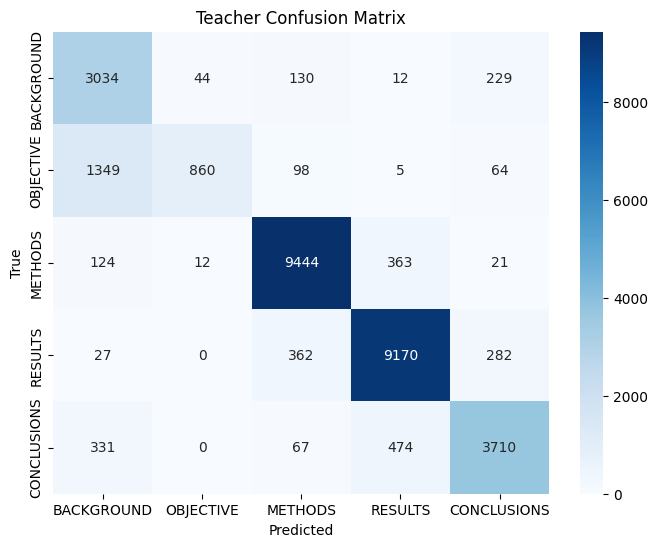


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.62      0.88      0.73      3449
   OBJECTIVE       0.94      0.36      0.52      2376
     METHODS       0.93      0.95      0.94      9964
     RESULTS       0.91      0.93      0.92      9841
 CONCLUSIONS       0.86      0.81      0.83      4582

    accuracy                           0.87     30212
   macro avg       0.85      0.79      0.79     30212
weighted avg       0.88      0.87      0.86     30212

[Teacher] Epoch 1, Val Loss: 0.3493, Accuracy: 0.8678, F1 Score: 0.8622


Teacher Epoch 2: 100%|██████████| 11253/11253 [30:36<00:00,  6.13it/s]


[Teacher] Epoch 2, Train Loss: 0.3381, Train Accuracy: 0.8766


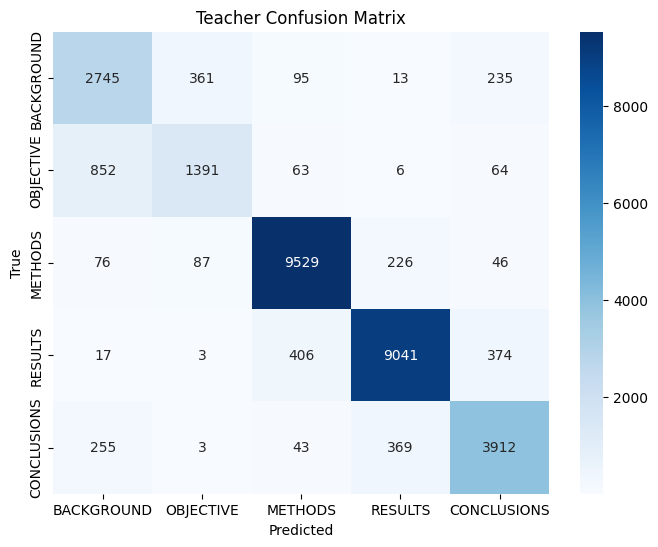


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.70      0.80      0.74      3449
   OBJECTIVE       0.75      0.59      0.66      2376
     METHODS       0.94      0.96      0.95      9964
     RESULTS       0.94      0.92      0.93      9841
 CONCLUSIONS       0.84      0.85      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.83      0.82      0.83     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 2, Val Loss: 0.3260, Accuracy: 0.8810, F1 Score: 0.8802


Teacher Epoch 3: 100%|██████████| 11253/11253 [30:29<00:00,  6.15it/s]


[Teacher] Epoch 3, Train Loss: 0.2857, Train Accuracy: 0.8950


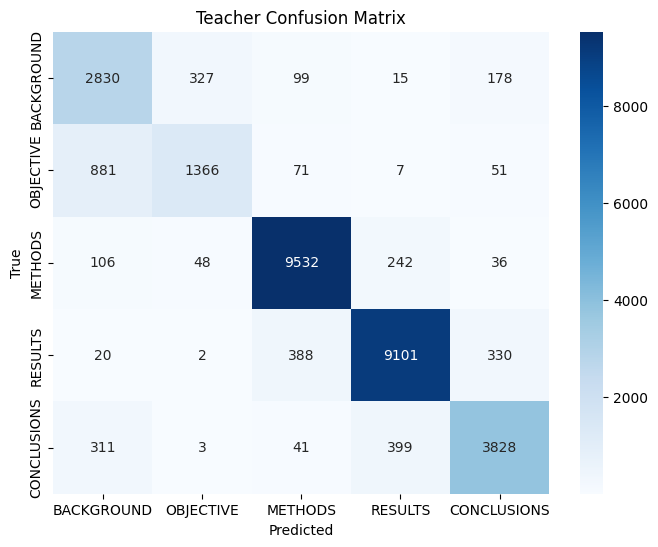


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.68      0.82      0.75      3449
   OBJECTIVE       0.78      0.57      0.66      2376
     METHODS       0.94      0.96      0.95      9964
     RESULTS       0.93      0.92      0.93      9841
 CONCLUSIONS       0.87      0.84      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.82      0.83     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 3, Val Loss: 0.3280, Accuracy: 0.8823, F1 Score: 0.8814


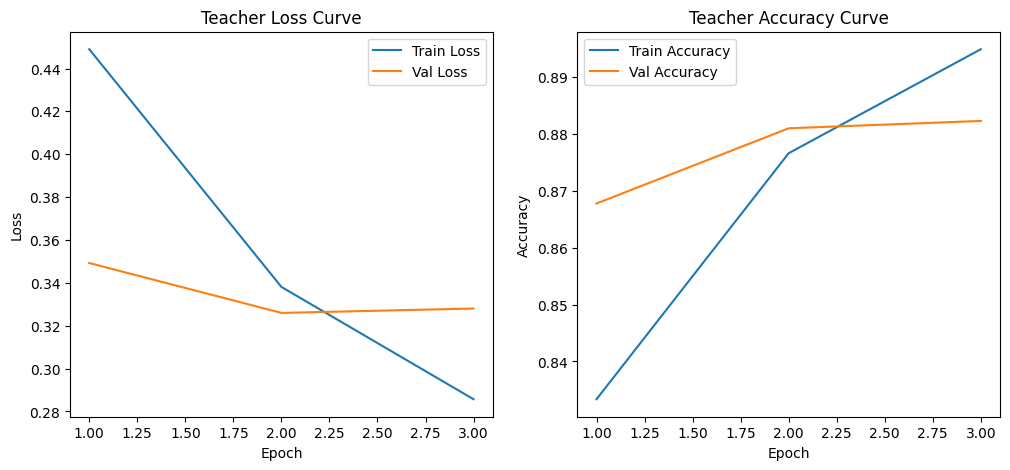

*** New best teacher model saved with val_acc=0.8823 ***

Testing freeze_n=2, epochs=3, lr=3e-05, batch_size=16, weight_decay=0.01


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training teacher with freeze_n=2 on cuda


Teacher Epoch 1: 100%|██████████| 11253/11253 [29:25<00:00,  6.37it/s]


[Teacher] Epoch 1, Train Loss: 0.4460, Train Accuracy: 0.8362


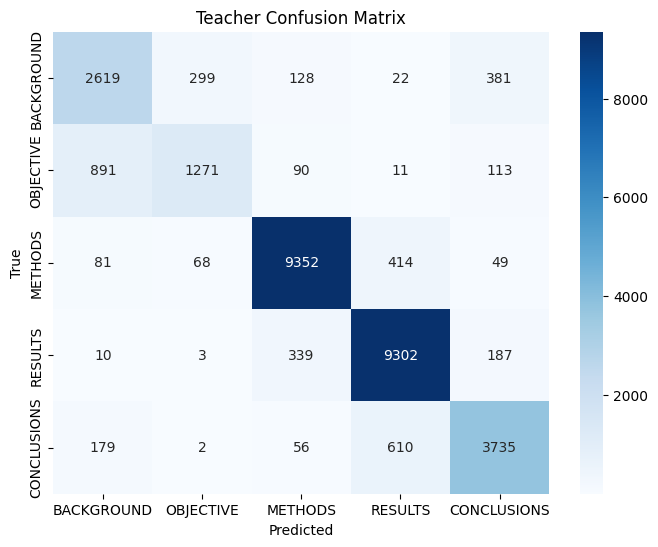


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.69      0.76      0.72      3449
   OBJECTIVE       0.77      0.53      0.63      2376
     METHODS       0.94      0.94      0.94      9964
     RESULTS       0.90      0.95      0.92      9841
 CONCLUSIONS       0.84      0.82      0.83      4582

    accuracy                           0.87     30212
   macro avg       0.83      0.80      0.81     30212
weighted avg       0.87      0.87      0.87     30212

[Teacher] Epoch 1, Val Loss: 0.3616, Accuracy: 0.8698, F1 Score: 0.8672


Teacher Epoch 2: 100%|██████████| 11253/11253 [30:56<00:00,  6.06it/s]


[Teacher] Epoch 2, Train Loss: 0.3427, Train Accuracy: 0.8756


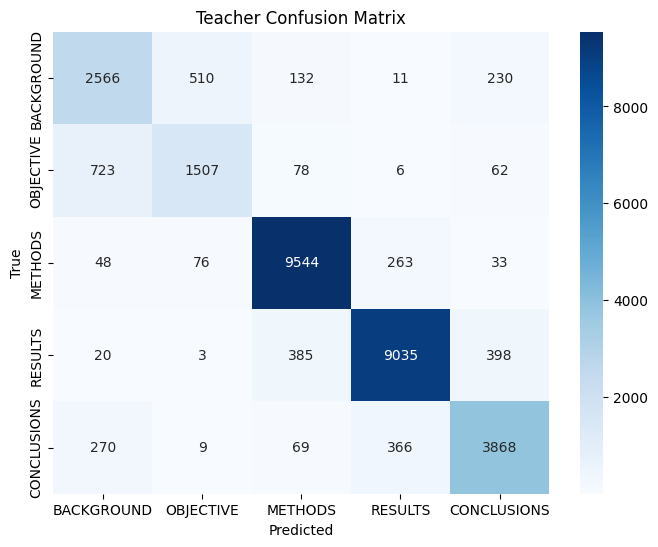


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.71      0.74      0.73      3449
   OBJECTIVE       0.72      0.63      0.67      2376
     METHODS       0.93      0.96      0.95      9964
     RESULTS       0.93      0.92      0.93      9841
 CONCLUSIONS       0.84      0.84      0.84      4582

    accuracy                           0.88     30212
   macro avg       0.83      0.82      0.82     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 2, Val Loss: 0.3370, Accuracy: 0.8778, F1 Score: 0.8772


Teacher Epoch 3: 100%|██████████| 11253/11253 [30:05<00:00,  6.23it/s]


[Teacher] Epoch 3, Train Loss: 0.2843, Train Accuracy: 0.8951


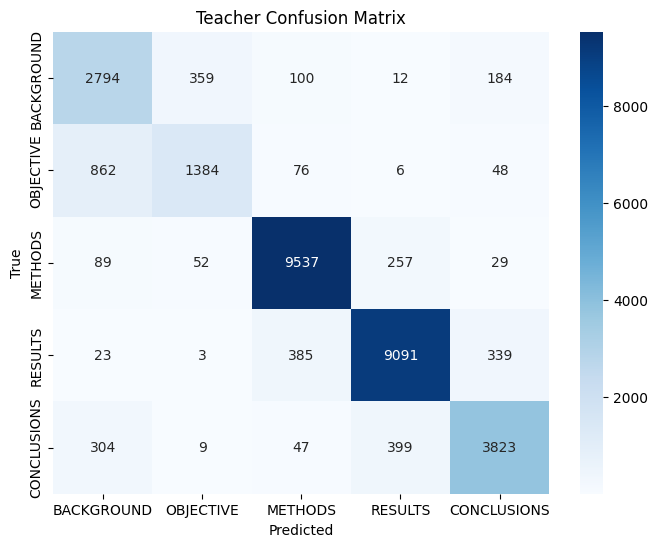


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.69      0.81      0.74      3449
   OBJECTIVE       0.77      0.58      0.66      2376
     METHODS       0.94      0.96      0.95      9964
     RESULTS       0.93      0.92      0.93      9841
 CONCLUSIONS       0.86      0.83      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.82      0.83     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 3, Val Loss: 0.3298, Accuracy: 0.8814, F1 Score: 0.8805


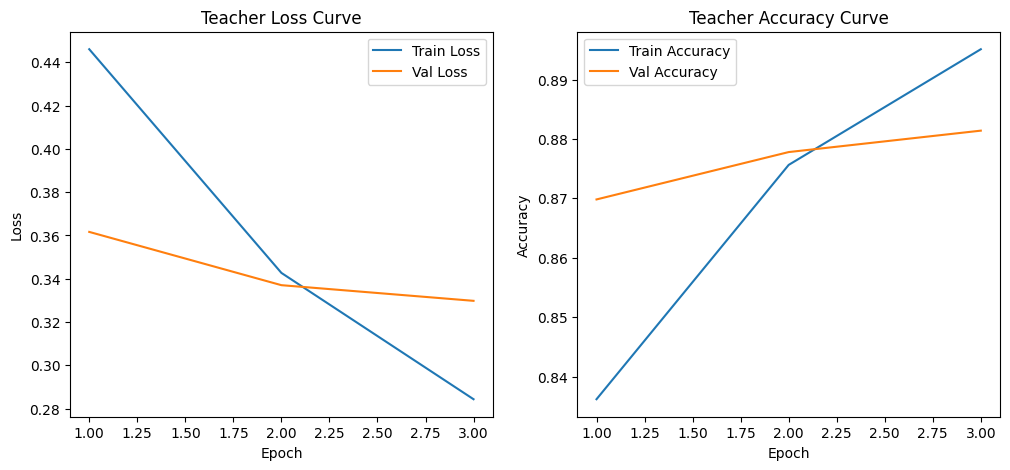


Testing freeze_n=2, epochs=3, lr=5e-06, batch_size=16, weight_decay=0.01


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training teacher with freeze_n=2 on cuda


Teacher Epoch 1: 100%|██████████| 11253/11253 [28:30<00:00,  6.58it/s]


[Teacher] Epoch 1, Train Loss: 0.4816, Train Accuracy: 0.8214


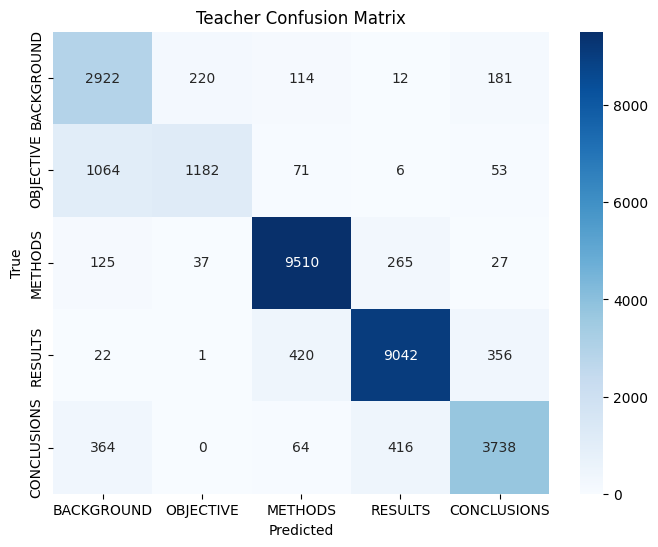


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.65      0.85      0.74      3449
   OBJECTIVE       0.82      0.50      0.62      2376
     METHODS       0.93      0.95      0.94      9964
     RESULTS       0.93      0.92      0.92      9841
 CONCLUSIONS       0.86      0.82      0.84      4582

    accuracy                           0.87     30212
   macro avg       0.84      0.81      0.81     30212
weighted avg       0.88      0.87      0.87     30212

[Teacher] Epoch 1, Val Loss: 0.3411, Accuracy: 0.8736, F1 Score: 0.8718


Teacher Epoch 2: 100%|██████████| 11253/11253 [28:33<00:00,  6.57it/s]


[Teacher] Epoch 2, Train Loss: 0.3476, Train Accuracy: 0.8741


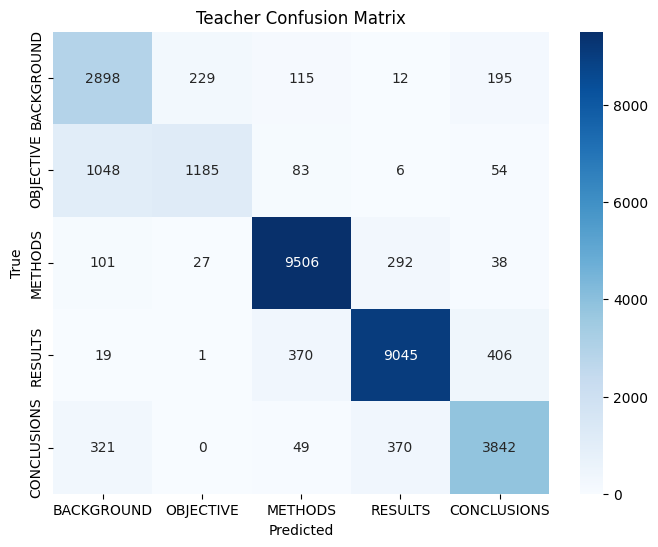


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.66      0.84      0.74      3449
   OBJECTIVE       0.82      0.50      0.62      2376
     METHODS       0.94      0.95      0.95      9964
     RESULTS       0.93      0.92      0.92      9841
 CONCLUSIONS       0.85      0.84      0.84      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.81      0.81     30212
weighted avg       0.88      0.88      0.87     30212

[Teacher] Epoch 2, Val Loss: 0.3311, Accuracy: 0.8763, F1 Score: 0.8744


Teacher Epoch 3: 100%|██████████| 11253/11253 [28:52<00:00,  6.50it/s]


[Teacher] Epoch 3, Train Loss: 0.3188, Train Accuracy: 0.8835


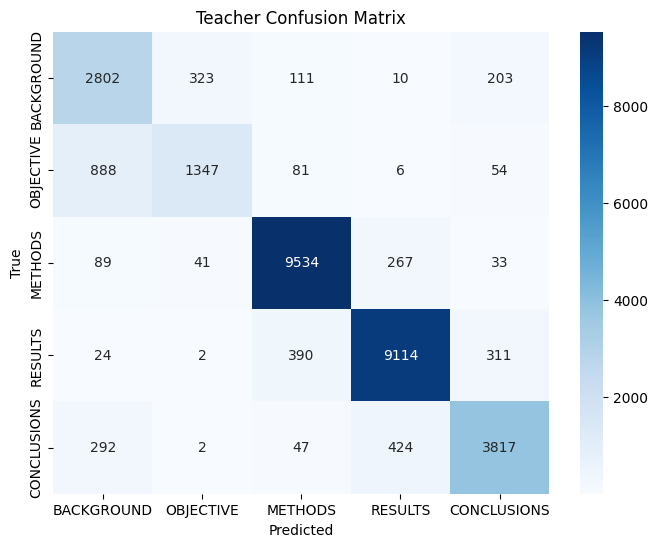


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.68      0.81      0.74      3449
   OBJECTIVE       0.79      0.57      0.66      2376
     METHODS       0.94      0.96      0.95      9964
     RESULTS       0.93      0.93      0.93      9841
 CONCLUSIONS       0.86      0.83      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.82      0.82     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 3, Val Loss: 0.3265, Accuracy: 0.8809, F1 Score: 0.8797


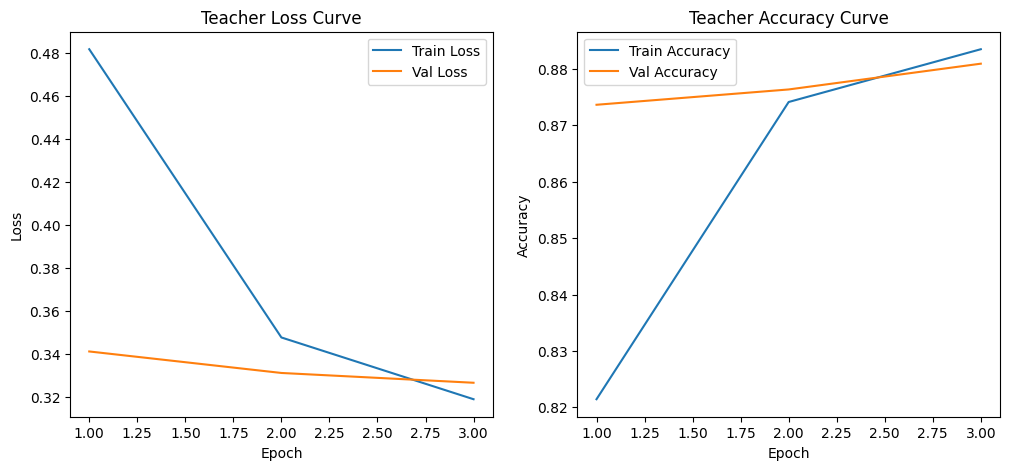


Testing freeze_n=2, epochs=4, lr=1e-05, batch_size=16, weight_decay=0.01


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training teacher with freeze_n=2 on cuda


Teacher Epoch 1: 100%|██████████| 11253/11253 [28:32<00:00,  6.57it/s]


[Teacher] Epoch 1, Train Loss: 0.4724, Train Accuracy: 0.8209


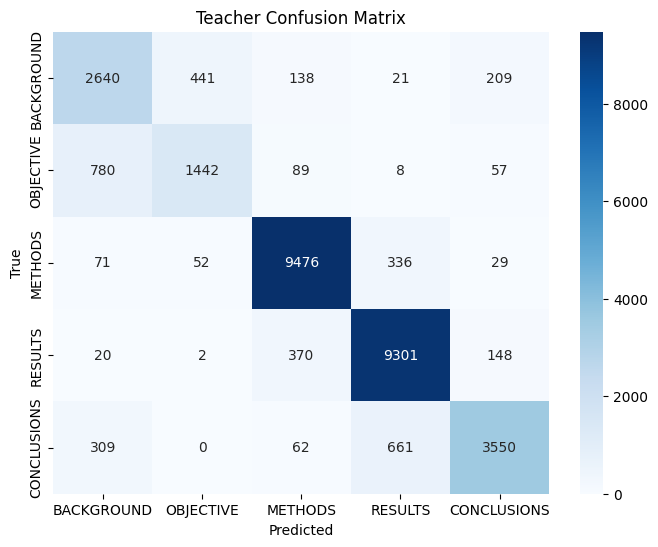


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.69      0.77      0.73      3449
   OBJECTIVE       0.74      0.61      0.67      2376
     METHODS       0.93      0.95      0.94      9964
     RESULTS       0.90      0.95      0.92      9841
 CONCLUSIONS       0.89      0.77      0.83      4582

    accuracy                           0.87     30212
   macro avg       0.83      0.81      0.82     30212
weighted avg       0.87      0.87      0.87     30212

[Teacher] Epoch 1, Val Loss: 0.3447, Accuracy: 0.8741, F1 Score: 0.8725


Teacher Epoch 2: 100%|██████████| 11253/11253 [28:34<00:00,  6.56it/s]


[Teacher] Epoch 2, Train Loss: 0.3433, Train Accuracy: 0.8750


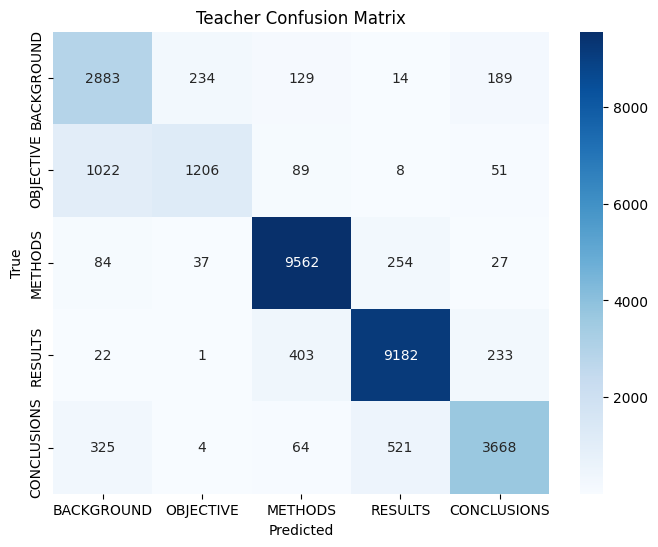


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.66      0.84      0.74      3449
   OBJECTIVE       0.81      0.51      0.63      2376
     METHODS       0.93      0.96      0.95      9964
     RESULTS       0.92      0.93      0.93      9841
 CONCLUSIONS       0.88      0.80      0.84      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.81      0.82     30212
weighted avg       0.88      0.88      0.87     30212

[Teacher] Epoch 2, Val Loss: 0.3298, Accuracy: 0.8772, F1 Score: 0.8747


Teacher Epoch 3: 100%|██████████| 11253/11253 [28:35<00:00,  6.56it/s]


[Teacher] Epoch 3, Train Loss: 0.3038, Train Accuracy: 0.8882


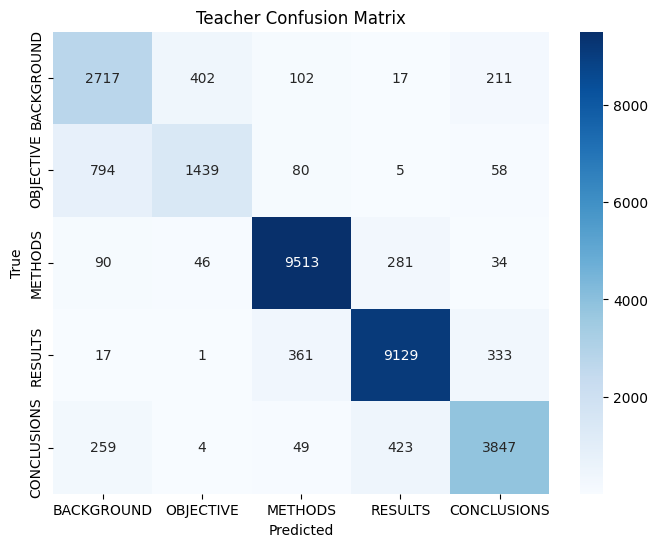


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.70      0.79      0.74      3449
   OBJECTIVE       0.76      0.61      0.67      2376
     METHODS       0.94      0.95      0.95      9964
     RESULTS       0.93      0.93      0.93      9841
 CONCLUSIONS       0.86      0.84      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.82      0.83     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 3, Val Loss: 0.3250, Accuracy: 0.8819, F1 Score: 0.8810


Teacher Epoch 4: 100%|██████████| 11253/11253 [28:35<00:00,  6.56it/s]


[Teacher] Epoch 4, Train Loss: 0.2721, Train Accuracy: 0.8992


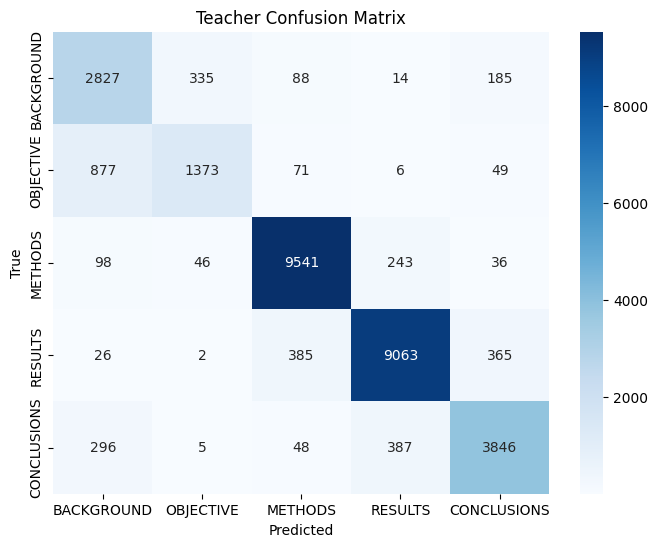


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.69      0.82      0.75      3449
   OBJECTIVE       0.78      0.58      0.66      2376
     METHODS       0.94      0.96      0.95      9964
     RESULTS       0.93      0.92      0.93      9841
 CONCLUSIONS       0.86      0.84      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.82      0.83     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 4, Val Loss: 0.3294, Accuracy: 0.8821, F1 Score: 0.8812


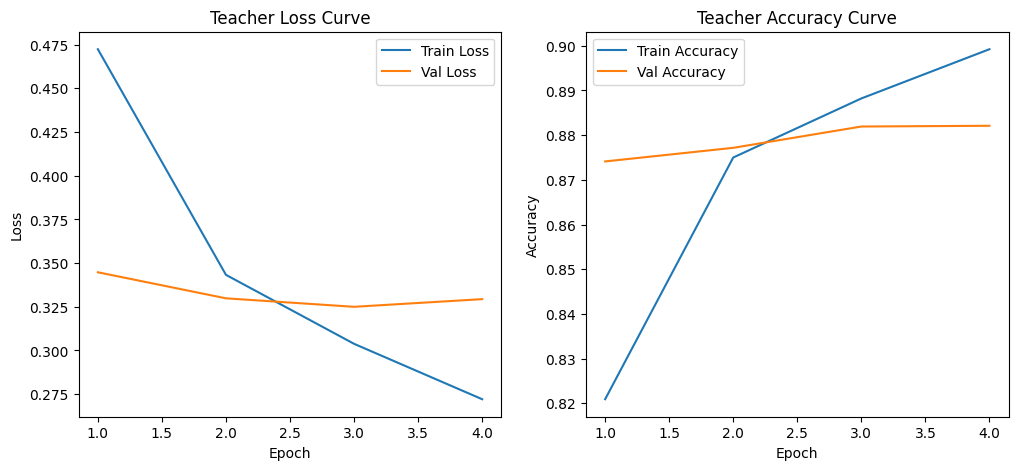


Testing freeze_n=2, epochs=4, lr=2e-05, batch_size=16, weight_decay=0.01


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training teacher with freeze_n=2 on cuda


Teacher Epoch 1: 100%|██████████| 11253/11253 [29:41<00:00,  6.32it/s]


[Teacher] Epoch 1, Train Loss: 0.4558, Train Accuracy: 0.8305


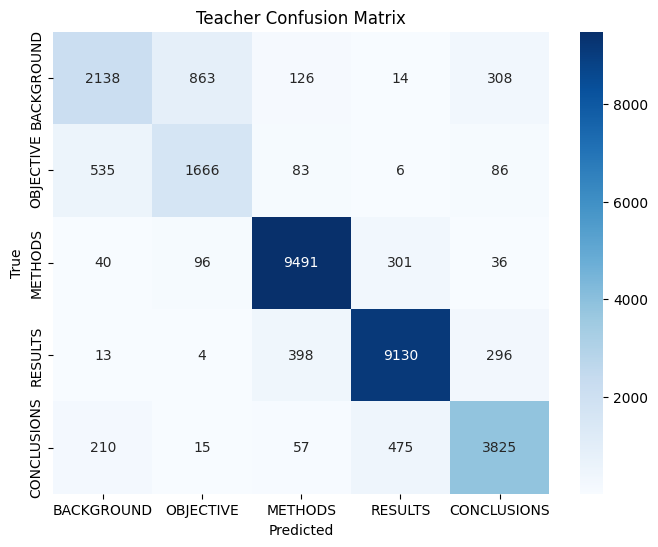


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.73      0.62      0.67      3449
   OBJECTIVE       0.63      0.70      0.66      2376
     METHODS       0.93      0.95      0.94      9964
     RESULTS       0.92      0.93      0.92      9841
 CONCLUSIONS       0.84      0.83      0.84      4582

    accuracy                           0.87     30212
   macro avg       0.81      0.81      0.81     30212
weighted avg       0.87      0.87      0.87     30212

[Teacher] Epoch 1, Val Loss: 0.3568, Accuracy: 0.8689, F1 Score: 0.8677


Teacher Epoch 2: 100%|██████████| 11253/11253 [30:19<00:00,  6.18it/s]


[Teacher] Epoch 2, Train Loss: 0.3453, Train Accuracy: 0.8746


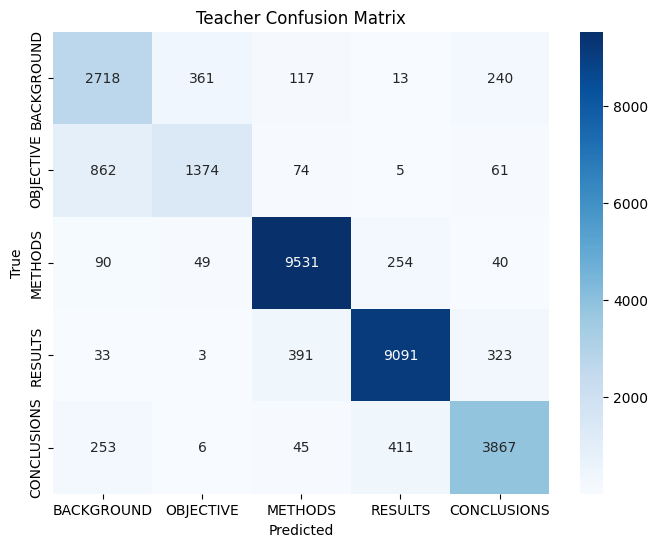


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.69      0.79      0.73      3449
   OBJECTIVE       0.77      0.58      0.66      2376
     METHODS       0.94      0.96      0.95      9964
     RESULTS       0.93      0.92      0.93      9841
 CONCLUSIONS       0.85      0.84      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.82      0.82     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 2, Val Loss: 0.3321, Accuracy: 0.8798, F1 Score: 0.8787


Teacher Epoch 3: 100%|██████████| 11253/11253 [29:38<00:00,  6.33it/s]


[Teacher] Epoch 3, Train Loss: 0.2967, Train Accuracy: 0.8911


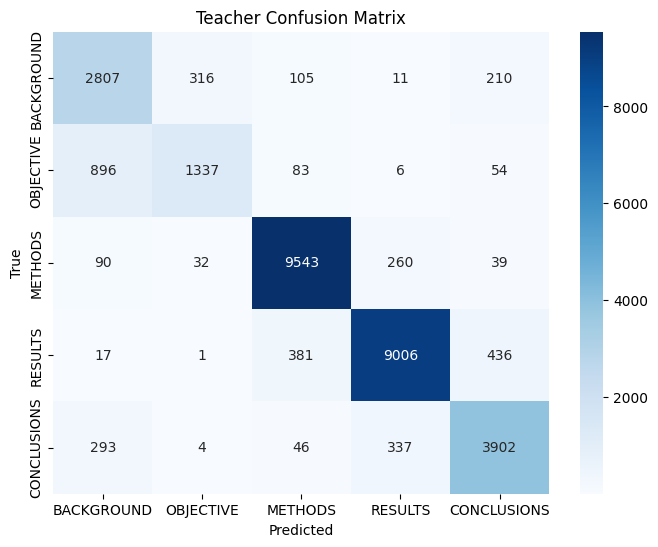


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.68      0.81      0.74      3449
   OBJECTIVE       0.79      0.56      0.66      2376
     METHODS       0.94      0.96      0.95      9964
     RESULTS       0.94      0.92      0.93      9841
 CONCLUSIONS       0.84      0.85      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.82      0.82     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 3, Val Loss: 0.3321, Accuracy: 0.8803, F1 Score: 0.8792


Teacher Epoch 4: 100%|██████████| 11253/11253 [30:00<00:00,  6.25it/s]


[Teacher] Epoch 4, Train Loss: 0.2535, Train Accuracy: 0.9063


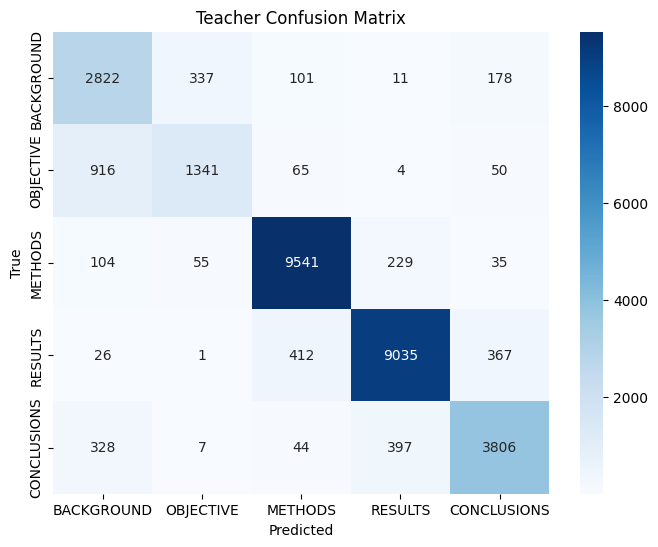


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.67      0.82      0.74      3449
   OBJECTIVE       0.77      0.56      0.65      2376
     METHODS       0.94      0.96      0.95      9964
     RESULTS       0.93      0.92      0.93      9841
 CONCLUSIONS       0.86      0.83      0.84      4582

    accuracy                           0.88     30212
   macro avg       0.83      0.82      0.82     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 4, Val Loss: 0.3446, Accuracy: 0.8786, F1 Score: 0.8778


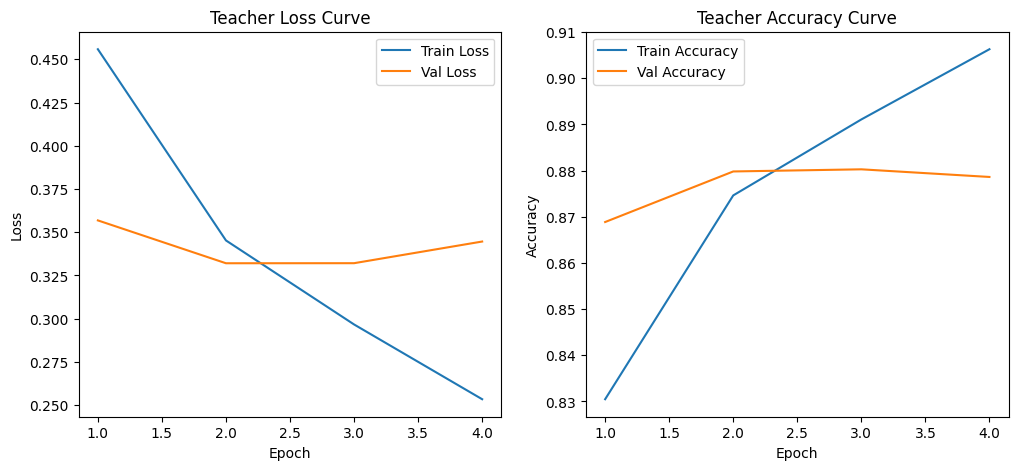


Testing freeze_n=2, epochs=4, lr=3e-05, batch_size=16, weight_decay=0.01


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training teacher with freeze_n=2 on cuda


Teacher Epoch 1: 100%|██████████| 11253/11253 [30:16<00:00,  6.19it/s]


[Teacher] Epoch 1, Train Loss: 0.4576, Train Accuracy: 0.8307


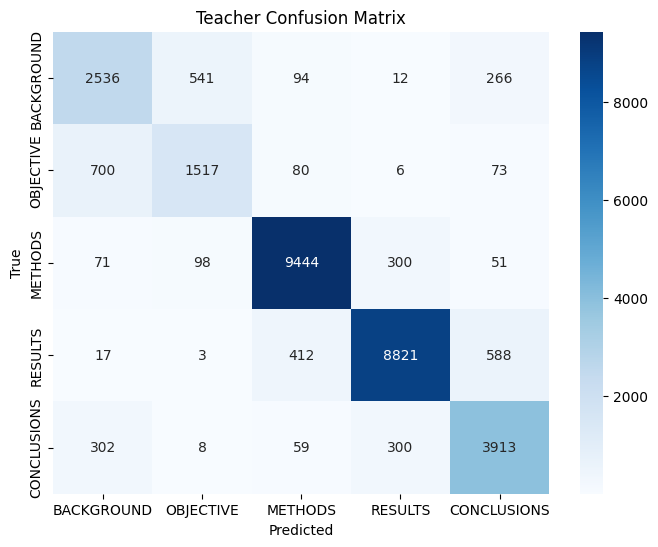


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.70      0.74      0.72      3449
   OBJECTIVE       0.70      0.64      0.67      2376
     METHODS       0.94      0.95      0.94      9964
     RESULTS       0.93      0.90      0.92      9841
 CONCLUSIONS       0.80      0.85      0.83      4582

    accuracy                           0.87     30212
   macro avg       0.81      0.81      0.81     30212
weighted avg       0.87      0.87      0.87     30212

[Teacher] Epoch 1, Val Loss: 0.3669, Accuracy: 0.8682, F1 Score: 0.8684


Teacher Epoch 2: 100%|██████████| 11253/11253 [29:17<00:00,  6.40it/s]


[Teacher] Epoch 2, Train Loss: 0.3530, Train Accuracy: 0.8718


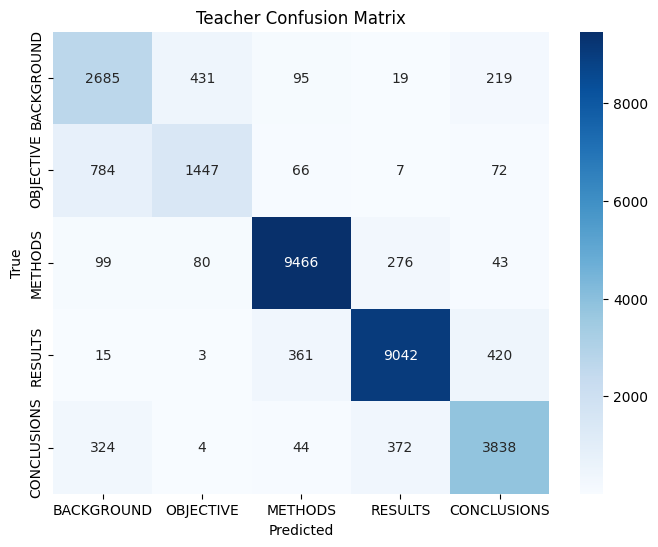


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.69      0.78      0.73      3449
   OBJECTIVE       0.74      0.61      0.67      2376
     METHODS       0.94      0.95      0.95      9964
     RESULTS       0.93      0.92      0.92      9841
 CONCLUSIONS       0.84      0.84      0.84      4582

    accuracy                           0.88     30212
   macro avg       0.83      0.82      0.82     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 2, Val Loss: 0.3398, Accuracy: 0.8764, F1 Score: 0.8761


Teacher Epoch 3: 100%|██████████| 11253/11253 [29:34<00:00,  6.34it/s]


[Teacher] Epoch 3, Train Loss: 0.3025, Train Accuracy: 0.8889


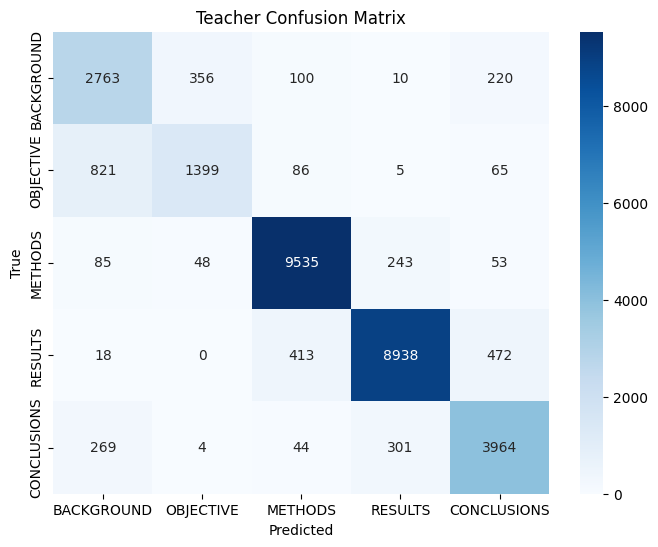


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.70      0.80      0.75      3449
   OBJECTIVE       0.77      0.59      0.67      2376
     METHODS       0.94      0.96      0.95      9964
     RESULTS       0.94      0.91      0.92      9841
 CONCLUSIONS       0.83      0.87      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.82      0.83     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 3, Val Loss: 0.3346, Accuracy: 0.8804, F1 Score: 0.8797


Teacher Epoch 4: 100%|██████████| 11253/11253 [29:06<00:00,  6.44it/s]


[Teacher] Epoch 4, Train Loss: 0.2539, Train Accuracy: 0.9064


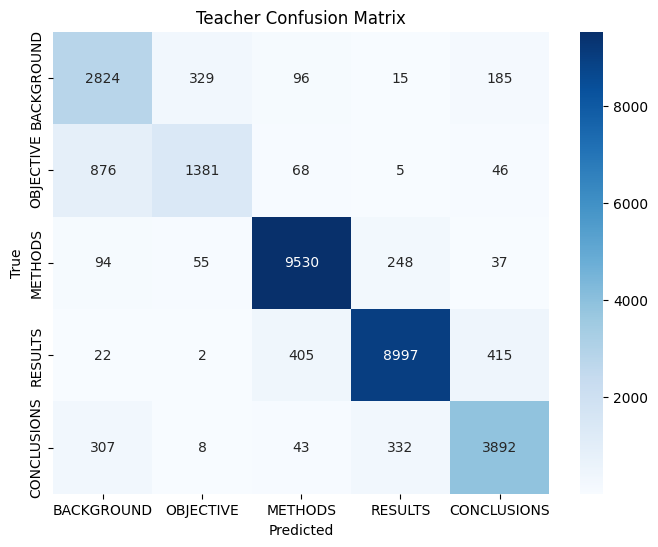


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.68      0.82      0.75      3449
   OBJECTIVE       0.78      0.58      0.67      2376
     METHODS       0.94      0.96      0.95      9964
     RESULTS       0.94      0.91      0.93      9841
 CONCLUSIONS       0.85      0.85      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.82      0.83     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 4, Val Loss: 0.3461, Accuracy: 0.8812, F1 Score: 0.8806


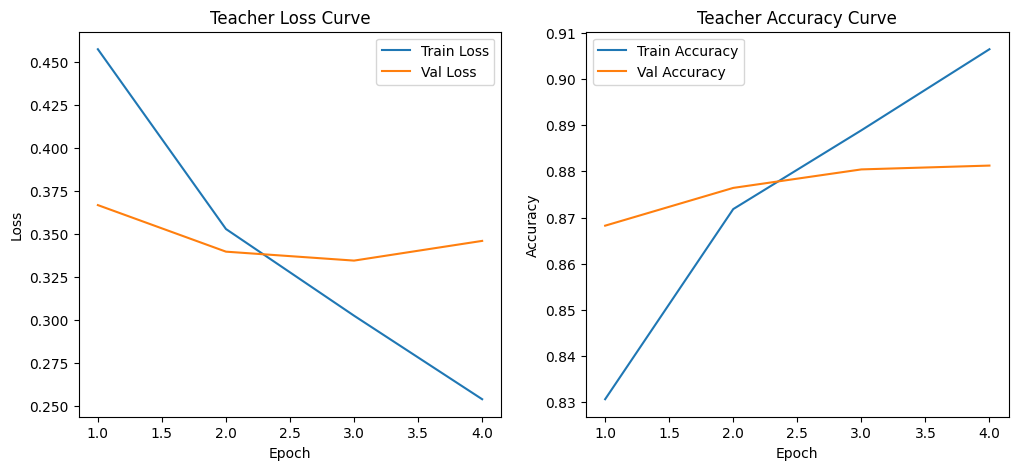


Testing freeze_n=2, epochs=4, lr=5e-06, batch_size=16, weight_decay=0.01


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training teacher with freeze_n=2 on cuda


Teacher Epoch 1: 100%|██████████| 11253/11253 [30:20<00:00,  6.18it/s]


[Teacher] Epoch 1, Train Loss: 0.5004, Train Accuracy: 0.8105


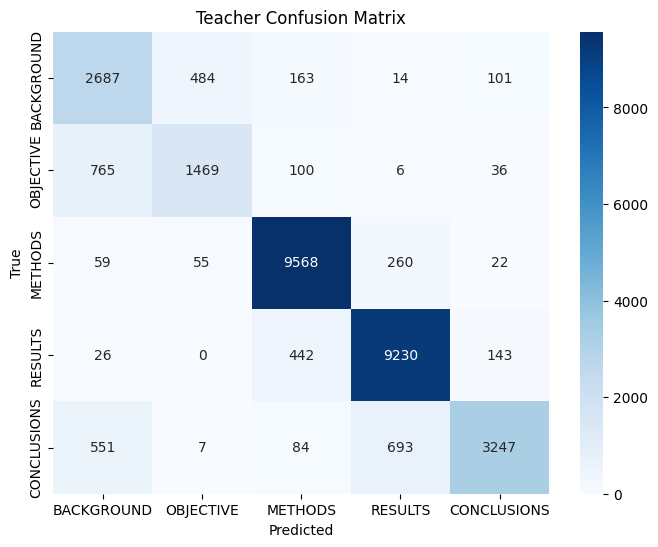


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.66      0.78      0.71      3449
   OBJECTIVE       0.73      0.62      0.67      2376
     METHODS       0.92      0.96      0.94      9964
     RESULTS       0.90      0.94      0.92      9841
 CONCLUSIONS       0.91      0.71      0.80      4582

    accuracy                           0.87     30212
   macro avg       0.83      0.80      0.81     30212
weighted avg       0.87      0.87      0.87     30212

[Teacher] Epoch 1, Val Loss: 0.3643, Accuracy: 0.8672, F1 Score: 0.8657


Teacher Epoch 2: 100%|██████████| 11253/11253 [30:29<00:00,  6.15it/s]


[Teacher] Epoch 2, Train Loss: 0.3525, Train Accuracy: 0.8716


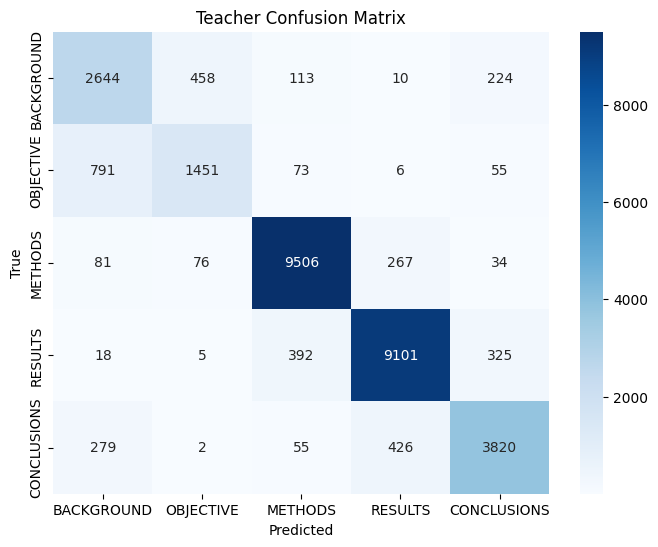


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.69      0.77      0.73      3449
   OBJECTIVE       0.73      0.61      0.66      2376
     METHODS       0.94      0.95      0.95      9964
     RESULTS       0.93      0.92      0.93      9841
 CONCLUSIONS       0.86      0.83      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.83      0.82      0.82     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 2, Val Loss: 0.3314, Accuracy: 0.8779, F1 Score: 0.8772


Teacher Epoch 3: 100%|██████████| 11253/11253 [30:27<00:00,  6.16it/s]


[Teacher] Epoch 3, Train Loss: 0.3221, Train Accuracy: 0.8821


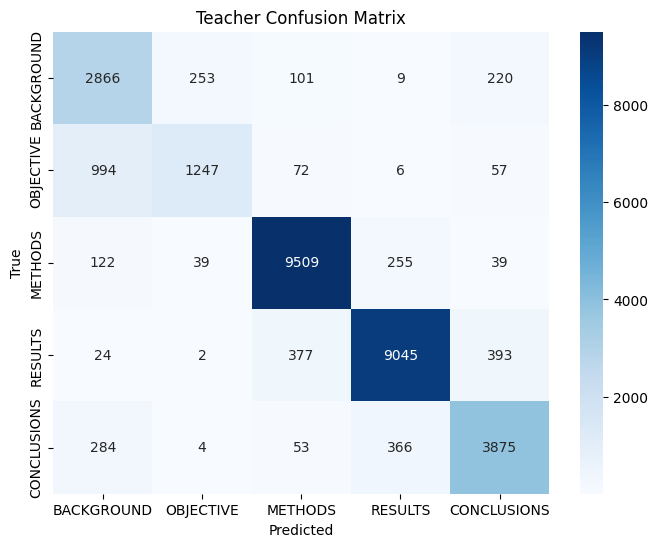


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.67      0.83      0.74      3449
   OBJECTIVE       0.81      0.52      0.64      2376
     METHODS       0.94      0.95      0.95      9964
     RESULTS       0.93      0.92      0.93      9841
 CONCLUSIONS       0.85      0.85      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.81      0.82     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 3, Val Loss: 0.3289, Accuracy: 0.8785, F1 Score: 0.8771


Teacher Epoch 4: 100%|██████████| 11253/11253 [29:51<00:00,  6.28it/s]


[Teacher] Epoch 4, Train Loss: 0.3014, Train Accuracy: 0.8893


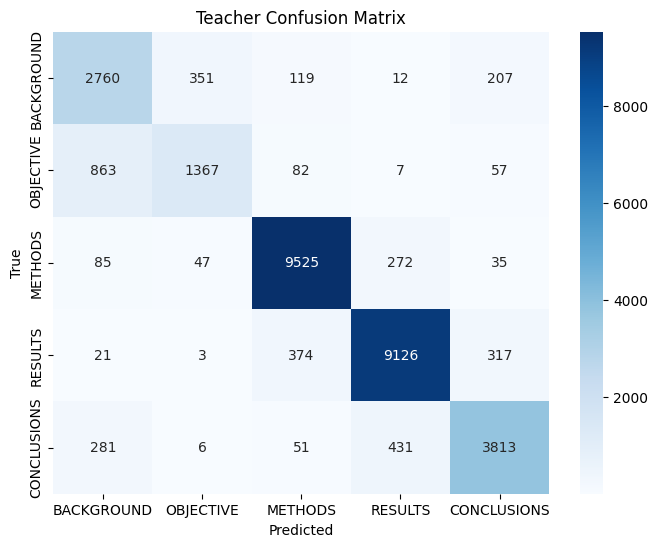


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.69      0.80      0.74      3449
   OBJECTIVE       0.77      0.58      0.66      2376
     METHODS       0.94      0.96      0.95      9964
     RESULTS       0.93      0.93      0.93      9841
 CONCLUSIONS       0.86      0.83      0.85      4582

    accuracy                           0.88     30212
   macro avg       0.84      0.82      0.82     30212
weighted avg       0.88      0.88      0.88     30212

[Teacher] Epoch 4, Val Loss: 0.3275, Accuracy: 0.8801, F1 Score: 0.8789


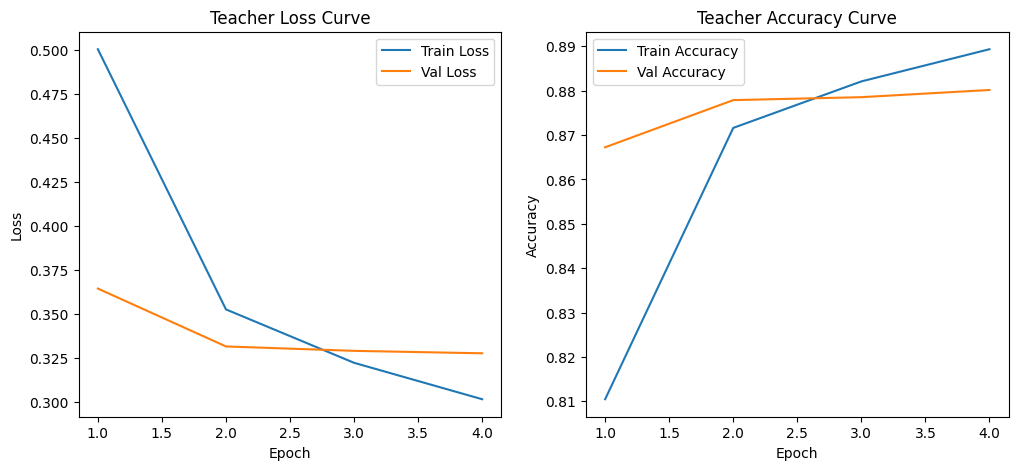


Evaluating best teacher model on test set...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


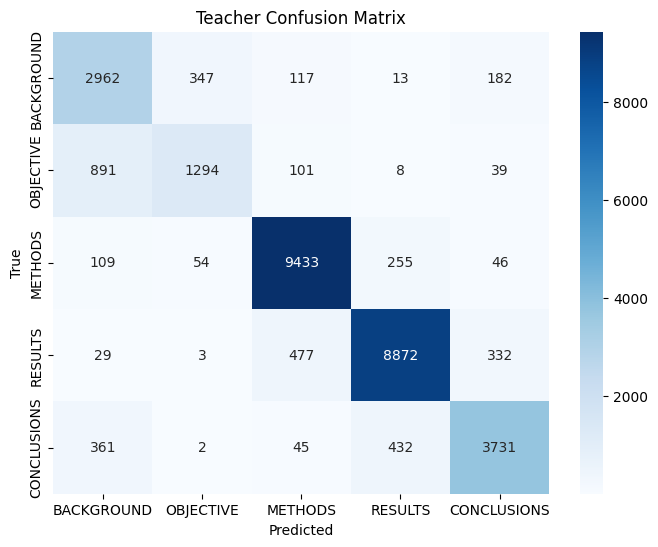


Teacher Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.68      0.82      0.74      3621
   OBJECTIVE       0.76      0.55      0.64      2333
     METHODS       0.93      0.95      0.94      9897
     RESULTS       0.93      0.91      0.92      9713
 CONCLUSIONS       0.86      0.82      0.84      4571

    accuracy                           0.87     30135
   macro avg       0.83      0.81      0.82     30135
weighted avg       0.87      0.87      0.87     30135

Teacher Final Test Accuracy: 0.8725, F1 Score: 0.8713


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import RobertaForSequenceClassification, RobertaTokenizer, DataCollatorWithPadding
from transformers.optimization import get_linear_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# class Config:
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     max_len = 128
#     teacher_epochs = [2, 3, 4]
#     teacher_lrs = [1e-5, 2e-5, 3e-5, 5e-5] # Added smaller lr for finer tuning
#     teacher_batch_sizes = [16, 32]
#     teacher_weight_decays = [0.0, 0.01]
#     teacher_freeze_configs = [0, 2, 4, 6, 8, 10]  # Number of RoBERTa layers to freeze
#     output_teacher_model = "best_teacher_model.pt"

# Configuration
class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    max_len = 128
    teacher_epochs = [3, 4]
    teacher_lrs = [1e-5, 2e-5, 3e-5, 5e-6] # Added smaller lr for finer tuning
    teacher_batch_sizes = [16]
    teacher_weight_decays = [0.01]
    teacher_freeze_configs = [2]
    output_teacher_model = "best_teacher_model2.pt"
# class Config:
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     max_len = 128
#     teacher_epochs = [4]
#     teacher_lrs = [1e-5, 2e-5, 3e-5, 5e-5]  # Added smaller lr for finer tuning
#     teacher_batch_sizes = [16, 32]
#     teacher_weight_decays = [0.0, 0.01]
#     teacher_freeze_configs = [0]  # Number of RoBERTa layers to freeze
#     output_teacher_model = "best_teacher_model.pt"

# Verify GPU Availability
print(f"Using device: {Config.device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU detected. Falling back to CPU.")

# Custom Data Collator
class CustomDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.padding_collator = DataCollatorWithPadding(tokenizer)

    def __call__(self, examples):
        features = [{"input_ids": ex["input_ids"], "attention_mask": ex["attention_mask"]} for ex in examples]
        labels = [ex["label"] for ex in examples]
        padded = self.padding_collator(features)
        padded["label"] = torch.tensor(labels, dtype=torch.long)
        return padded

# Freeze Transformer Layers
def freeze_transformer_layers(model, freeze_n):
    """Freeze the specified number of RoBERTa encoder layers."""
    if hasattr(model, 'roberta'):
        backbone = model.roberta
    else:
        raise ValueError("Model does not have 'roberta' attribute.")
    
    # Freeze embeddings if freeze_n > 0
    for param in backbone.embeddings.parameters():
        param.requires_grad = False if freeze_n > 0 else True
    
    # Freeze encoder layers
    for i, layer in enumerate(backbone.encoder.layer):
        for param in layer.parameters():
            param.requires_grad = (i >= freeze_n)
    
    # Ensure classifier is trainable
    for param in model.classifier.parameters():
        param.requires_grad = True

# Evaluation Function
def evaluate(model, dataloader, device, model_name="Teacher"):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"],
                yticklabels=["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Classification Report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"]))
    
    return total_loss / len(dataloader), acc, f1, all_preds, all_labels

# Teacher Training with Plots
def train_teacher(model, train_loader, val_loader, epochs, lr, weight_decay, device, freeze_n):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)
    best_acc = 0.0
    best_state_dict = None
    train_losses, val_losses, train_accs, val_accs = [], [], [], []  # Fixed unpacking error
    
    print(f"Training teacher with freeze_n={freeze_n} on {device}")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []
        for batch in tqdm(train_loader, desc=f"Teacher Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"[Teacher] Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, device, model_name="Teacher")
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"[Teacher] Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_state_dict = model.state_dict()

    # Plot Training and Validation Metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Teacher Loss Curve')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Teacher Accuracy Curve')
    plt.legend()
    plt.show()
    
    return best_acc, best_state_dict

# Main Function
def main():
    # Load Dataset
    print("Loading PubMed RCT dataset...")
    dataset = load_dataset(
        "csv",
        data_files={
            "train": "data/train.txt",
            "validation": "data/dev.txt",
            "test": "data/test.txt"
        },
        delimiter="\t",
        column_names=["label", "text"]
    )

    # Filter out non-data lines (e.g., document IDs starting with ###)
    valid_labels = {"BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"}
    dataset = dataset.filter(lambda x: x["label"] in valid_labels)
    train_dataset = dataset["train"]
    val_dataset = dataset["validation"]
    test_dataset = dataset["test"]

    # Define Label Map
    label_map = {"BACKGROUND": 0, "OBJECTIVE": 1, "METHODS": 2, "RESULTS": 3, "CONCLUSIONS": 4}
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

    # Preprocess Function
    def preprocess(example):
        encoding = tokenizer(
            example["text"],
            max_length=Config.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        label = label_map[example["label"]]
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": label
        }

    # Apply Preprocessing
    train_dataset = train_dataset.map(preprocess)
    val_dataset = val_dataset.map(preprocess)
    test_dataset = test_dataset.map(preprocess)
    train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    # Grid Search for Teacher
    print("\nStarting RoBERTa fine-tuning grid search...")
    teacher_results = []
    best_teacher_acc = 0.0
    best_teacher_state = None
    best_teacher_config = None

    for freeze_n in Config.teacher_freeze_configs:
        for epochs in Config.teacher_epochs:
            for lr in Config.teacher_lrs:
                for batch_size in Config.teacher_batch_sizes:
                    for weight_decay in Config.teacher_weight_decays:
                        print(f"\nTesting freeze_n={freeze_n}, epochs={epochs}, lr={lr}, batch_size={batch_size}, weight_decay={weight_decay}")
                        teacher = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=5).to(Config.device)
                        freeze_transformer_layers(teacher, freeze_n)
                        data_collator = CustomDataCollator(tokenizer=tokenizer)
                        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
                        val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=data_collator)
                        acc, state_dict = train_teacher(teacher, train_loader, val_loader, epochs, lr, weight_decay, Config.device, freeze_n)
                        teacher_results.append({
                            "freeze_n": freeze_n,
                            "epochs": epochs,
                            "lr": lr,
                            "batch_size": batch_size,
                            "weight_decay": weight_decay,
                            "val_acc": acc
                        })
                        if acc > best_teacher_acc:
                            best_teacher_acc = acc
                            best_teacher_state = state_dict
                            best_teacher_config = {
                                "freeze_n": freeze_n,
                                "epochs": epochs,
                                "lr": lr,
                                "batch_size": batch_size,
                                "weight_decay": weight_decay
                            }
                            torch.save(state_dict, Config.output_teacher_model)
                            print(f"*** New best teacher model saved with val_acc={acc:.4f} ***")

    # Save Grid Search Results
    with open("teacher_grid_results.json", "w") as f:
        json.dump(teacher_results, f, indent=2)

    # Load and Evaluate Best Teacher on Test Set
    print("\nEvaluating best teacher model on test set...")
    teacher = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=5).to(Config.device)
    teacher.load_state_dict(torch.load(Config.output_teacher_model))
    test_loader = DataLoader(test_dataset, batch_size=best_teacher_config["batch_size"], collate_fn=data_collator)
    _, teacher_acc, teacher_f1, _, _ = evaluate(teacher, test_loader, Config.device, model_name="Teacher")
    print(f"Teacher Final Test Accuracy: {teacher_acc:.4f}, F1 Score: {teacher_f1:.4f}")

if __name__ == "__main__":
    main()

freeze 3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import RobertaForSequenceClassification, RobertaTokenizer, DataCollatorWithPadding
from transformers.optimization import get_linear_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# class Config:
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     max_len = 128
#     teacher_epochs = [2, 3, 4]
#     teacher_lrs = [1e-5, 2e-5, 3e-5, 5e-5] # Added smaller lr for finer tuning
#     teacher_batch_sizes = [16, 32]
#     teacher_weight_decays = [0.0, 0.01]
#     teacher_freeze_configs = [0, 2, 4, 6, 8, 10]  # Number of RoBERTa layers to freeze
#     output_teacher_model = "best_teacher_model.pt"

# Configuration
class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    max_len = 128
    teacher_epochs = [3, 4]
    teacher_lrs = [1e-5, 2e-5, 3e-5, 5e-6] # Added smaller lr for finer tuning
    teacher_batch_sizes = [16,32]
    teacher_weight_decays = [0.0,0.01]
    teacher_freeze_configs = [4]
    output_teacher_model = "best_teacher_model3.pt"
# class Config:
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     max_len = 128
#     teacher_epochs = [4]
#     teacher_lrs = [1e-5, 2e-5, 3e-5, 5e-5]  # Added smaller lr for finer tuning
#     teacher_batch_sizes = [16, 32]
#     teacher_weight_decays = [0.0, 0.01]
#     teacher_freeze_configs = [0]  # Number of RoBERTa layers to freeze
#     output_teacher_model = "best_teacher_model.pt"

# Verify GPU Availability
print(f"Using device: {Config.device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU detected. Falling back to CPU.")

# Custom Data Collator
class CustomDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.padding_collator = DataCollatorWithPadding(tokenizer)

    def __call__(self, examples):
        features = [{"input_ids": ex["input_ids"], "attention_mask": ex["attention_mask"]} for ex in examples]
        labels = [ex["label"] for ex in examples]
        padded = self.padding_collator(features)
        padded["label"] = torch.tensor(labels, dtype=torch.long)
        return padded

# Freeze Transformer Layers
def freeze_transformer_layers(model, freeze_n):
    """Freeze the specified number of RoBERTa encoder layers."""
    if hasattr(model, 'roberta'):
        backbone = model.roberta
    else:
        raise ValueError("Model does not have 'roberta' attribute.")
    
    # Freeze embeddings if freeze_n > 0
    for param in backbone.embeddings.parameters():
        param.requires_grad = False if freeze_n > 0 else True
    
    # Freeze encoder layers
    for i, layer in enumerate(backbone.encoder.layer):
        for param in layer.parameters():
            param.requires_grad = (i >= freeze_n)
    
    # Ensure classifier is trainable
    for param in model.classifier.parameters():
        param.requires_grad = True

# Evaluation Function
def evaluate(model, dataloader, device, model_name="Teacher"):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"],
                yticklabels=["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Classification Report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"]))
    
    return total_loss / len(dataloader), acc, f1, all_preds, all_labels

# Teacher Training with Plots
def train_teacher(model, train_loader, val_loader, epochs, lr, weight_decay, device, freeze_n):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)
    best_acc = 0.0
    best_state_dict = None
    train_losses, val_losses, train_accs, val_accs = [], [], [], []  # Fixed unpacking error
    
    print(f"Training teacher with freeze_n={freeze_n} on {device}")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []
        for batch in tqdm(train_loader, desc=f"Teacher Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"[Teacher] Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, device, model_name="Teacher")
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"[Teacher] Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_state_dict = model.state_dict()

    # Plot Training and Validation Metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Teacher Loss Curve')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Teacher Accuracy Curve')
    plt.legend()
    plt.show()
    
    return best_acc, best_state_dict

# Main Function
def main():
    # Load Dataset
    print("Loading PubMed RCT dataset...")
    dataset = load_dataset(
        "csv",
        data_files={
            "train": "data/train.txt",
            "validation": "data/dev.txt",
            "test": "data/test.txt"
        },
        delimiter="\t",
        column_names=["label", "text"]
    )

    # Filter out non-data lines (e.g., document IDs starting with ###)
    valid_labels = {"BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"}
    dataset = dataset.filter(lambda x: x["label"] in valid_labels)
    train_dataset = dataset["train"]
    val_dataset = dataset["validation"]
    test_dataset = dataset["test"]

    # Define Label Map
    label_map = {"BACKGROUND": 0, "OBJECTIVE": 1, "METHODS": 2, "RESULTS": 3, "CONCLUSIONS": 4}
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

    # Preprocess Function
    def preprocess(example):
        encoding = tokenizer(
            example["text"],
            max_length=Config.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        label = label_map[example["label"]]
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": label
        }

    # Apply Preprocessing
    train_dataset = train_dataset.map(preprocess)
    val_dataset = val_dataset.map(preprocess)
    test_dataset = test_dataset.map(preprocess)
    train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    # Grid Search for Teacher
    print("\nStarting RoBERTa fine-tuning grid search...")
    teacher_results = []
    best_teacher_acc = 0.0
    best_teacher_state = None
    best_teacher_config = None

    for freeze_n in Config.teacher_freeze_configs:
        for epochs in Config.teacher_epochs:
            for lr in Config.teacher_lrs:
                for batch_size in Config.teacher_batch_sizes:
                    for weight_decay in Config.teacher_weight_decays:
                        print(f"\nTesting freeze_n={freeze_n}, epochs={epochs}, lr={lr}, batch_size={batch_size}, weight_decay={weight_decay}")
                        teacher = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=5).to(Config.device)
                        freeze_transformer_layers(teacher, freeze_n)
                        data_collator = CustomDataCollator(tokenizer=tokenizer)
                        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
                        val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=data_collator)
                        acc, state_dict = train_teacher(teacher, train_loader, val_loader, epochs, lr, weight_decay, Config.device, freeze_n)
                        teacher_results.append({
                            "freeze_n": freeze_n,
                            "epochs": epochs,
                            "lr": lr,
                            "batch_size": batch_size,
                            "weight_decay": weight_decay,
                            "val_acc": acc
                        })
                        if acc > best_teacher_acc:
                            best_teacher_acc = acc
                            best_teacher_state = state_dict
                            best_teacher_config = {
                                "freeze_n": freeze_n,
                                "epochs": epochs,
                                "lr": lr,
                                "batch_size": batch_size,
                                "weight_decay": weight_decay
                            }
                            torch.save(state_dict, Config.output_teacher_model)
                            print(f"*** New best teacher model saved with val_acc={acc:.4f} ***")

    # Save Grid Search Results
    with open("teacher_grid_results.json", "w") as f:
        json.dump(teacher_results, f, indent=2)

    # Load and Evaluate Best Teacher on Test Set
    print("\nEvaluating best teacher model on test set...")
    teacher = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=5).to(Config.device)
    teacher.load_state_dict(torch.load(Config.output_teacher_model))
    test_loader = DataLoader(test_dataset, batch_size=best_teacher_config["batch_size"], collate_fn=data_collator)
    _, teacher_acc, teacher_f1, _, _ = evaluate(teacher, test_loader, Config.device, model_name="Teacher")
    print(f"Teacher Final Test Accuracy: {teacher_acc:.4f}, F1 Score: {teacher_f1:.4f}")

if __name__ == "__main__":
    main()